In [3]:
from multiprocessing import Pool, cpu_count, get_context
import multiprocessing as mp
mp.set_start_method("fork", force=True)

import subprocess
import os
import uuid
import shutil
import h5py
import emcee
import time
from scipy.ndimage import gaussian_filter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import h5py
import os.path as osp

measurements = pd.read_csv('pca_version.txt', sep='\s+', names = ['wavelength', 'PC1_1', 'PC1_2', 'PC2_1', 'PC2_2'])

# Constants and paths
PGO_TEMPLATE = "asym_top_0.pgo"
JULIA_SCRIPT = "ingest_pgo_asymtop_emcee.jl"
TEMP_DIR = "pgo_temp"
os.makedirs(TEMP_DIR, exist_ok=True)

def filename_base(T, AB_base, C_base, frac_AB, frac_C):
    return f"T{T:.3f}_AB{AB_base:.7f}_C{C_base:.7f}_FAB{frac_AB:.5f}_FC{frac_C:.5f}"

def generate_pgopher_input(T, AB_base, C_base, frac_AB, frac_C):
    A_g = B_g = AB_base
    C_g = C_base
    A_e = B_e = AB_base * frac_AB
    C_e = C_base * frac_C

    base = filename_base(T, AB_base, C_base, frac_AB, frac_C)
    pgo_file = os.path.join(TEMP_DIR, f"temp_{base}.pgo")
    spec_txt = os.path.join(TEMP_DIR, f"spec_{base}.txt")

    awk_script = f'''
    awk -v temp="{T}" \\
        -v A_ground="{A_g}" -v B_ground="{B_g}" -v C_ground="{C_g}" \\
        -v A_excited="{A_e}" -v B_excited="{B_e}" -v C_excited="{C_e}" '
    BEGIN {{ inside_ground = 0; inside_excited = 0; }}
    /<Parameter Name="Temperature" Value="/ {{
        sub(/Value="[0-9.eE+-]+"/, "Value=\\"" temp "\\"")
    }}
    /<AsymmetricManifold Name="Ground"/ {{ inside_ground = 1 }}
    /<AsymmetricManifold Name="Excited"/ {{ inside_excited = 1 }}
    /<\\/AsymmetricManifold>/ {{ inside_ground = 0; inside_excited = 0 }}
    inside_ground && /<Parameter Name="A" Value="/ {{ sub(/Value="[0-9.eE+-]+"/, "Value=\\"" A_ground "\\"") }}
    inside_ground && /<Parameter Name="B" Value="/ {{ sub(/Value="[0-9.eE+-]+"/, "Value=\\"" B_ground "\\"") }}
    inside_ground && /<Parameter Name="C" Value="/ {{ sub(/Value="[0-9.eE+-]+"/, "Value=\\"" C_ground "\\"") }}
    inside_excited && /<Parameter Name="A" Value="/ {{ sub(/Value="[0-9.eE+-]+"/, "Value=\\"" A_excited "\\"") }}
    inside_excited && /<Parameter Name="B" Value="/ {{ sub(/Value="[0-9.eE+-]+"/, "Value=\\"" B_excited "\\"") }}
    inside_excited && /<Parameter Name="C" Value="/ {{ sub(/Value="[0-9.eE+-]+"/, "Value=\\"" C_excited "\\"") }}
    {{ print }}
    ' {PGO_TEMPLATE} > {pgo_file}
    '''

    subprocess.run(awk_script, shell=True, check=True, executable="/bin/bash")

    # Run PGOPHER
    subprocess.run(["./pgo", pgo_file, "-o", spec_txt], check=True, stdout=subprocess.DEVNULL)
    return spec_txt, base

def run_julia_convolution(spec_txt, base):
    output_h5 = os.path.join(TEMP_DIR, f"convolved_{base}")
    subprocess.run([
        "julia", JULIA_SCRIPT, spec_txt, output_h5
    ], check=True)
    return output_h5+'.h5'

def read_h5_spectrum(h5_file):
    with h5py.File(h5_file, "r") as f:
        # spectrum = f['spectra'][:, 0, 0, 0, 0, 0]
        spectrum = f['spectra'][:]
        wavelength = f['wavelengths'][:]
    return wavelength, spectrum

def log_prior(params):
    T, AB, C, frac_AB, frac_C = params

    # Log-normal prior on T
    if T <= 2 or T > 100:
        return -np.inf
    mu = np.log(30)
    sigma = 1
    temp_logprior = -np.log(T * sigma * np.sqrt(2 * np.pi)) - ((np.log(T) - mu)**2) / (2 * sigma**2)

    # AB flat prior: [0.001, 0.01]
    if AB < 0.001 or AB > 0.01:
        return -np.inf
    ab_logprior = 0.0

    # C flat prior: [0.004, 0.03]
    if C < 0.004 or C > 0.03:
        return -np.inf
    c_logprior = 0.0

    # Fraction AB prior: min at 1, falls off fast above 1
    if frac_AB < 1:
        return -np.inf
    frac_ab_logprior = -10 * (frac_AB - 1)**2  # steeper than Gaussian

    # Fraction C prior: min at 1, also steep falloff
    if frac_C < 1:
        return -np.inf
    frac_c_logprior = -10 * (frac_C - 1)**2

    return temp_logprior + ab_logprior + c_logprior + frac_ab_logprior + frac_c_logprior

def compute_loglikelihood(model_flux, model_flux_dT, data_flux, data_flux_dT, noise_std, noise_std_dT, c = 35, gf = 0.1):
    model_spec = gaussian_filter( model_flux[c:-c], gf)
    model_spec_dT = gaussian_filter( model_flux[c:-c], gf) - gaussian_filter( model_flux_dT[c:-c], gf)

    measurement = data_flux[c:-c]
    measurement_dT = data_flux_dT[c:-c]
    
    noise_std = noise_std[c:-c]
    noise_std_dT = noise_std_dT[c:-c]
    
    M = np.vstack([model_spec, np.ones_like(model_spec)]).T
    coeffs, _, _, _ = np.linalg.lstsq(M, measurement, rcond=None)
    scalar, offset = coeffs

    fit = scalar * model_spec + offset
    chi = (measurement - fit)/noise_std
    chi2 = np.sum(chi ** 2)

    # Build design matrix: [spec, model_spec, offset]
    M = np.vstack([model_spec, model_spec_dT, np.ones_like(model_spec)]).T

    # Solve for two scalars and offset
    coeffs, _, _, _ = np.linalg.lstsq(M, measurement_dT, rcond=None)
    scalar1, scalar2, offset = coeffs

    # Compute fit and residual
    fit = scalar1 * model_spec + scalar2 * model_spec_dT + offset
    chi = (measurement_dT - fit)/noise_std_dT

    chi2 += np.sum(chi ** 2)
                        
    return -0.5 * chi2

def model_log_likelihood(params, data_wavelength, data_flux, data_flux_dT, noise_std, noise_std_dT):

    lp = log_prior(params)
    if not np.isfinite(lp):
        return -np.inf
        
    try:
        
        T, AB_base, C_base, frac_AB, frac_C = params
        spec_txt, base = generate_pgopher_input(T, AB_base, C_base, frac_AB, frac_C)
        h5_file = run_julia_convolution(spec_txt, base)
        model_wavelength, model_flux = read_h5_spectrum(h5_file)
        
        spec_txt, base = generate_pgopher_input(T+0.05, AB_base, C_base, frac_AB, frac_C)
        h5_file = run_julia_convolution(spec_txt, base)
        _, model_flux_dT = read_h5_spectrum(h5_file)
        
        lnlike = compute_loglikelihood(model_flux, model_flux_dT, data_flux, data_flux_dT, noise_std, noise_std_dT)
        
        # Clean up
        os.remove(spec_txt)
        os.remove('pgo_temp/temp'+spec_txt[13:-4]+'.pgo')
        os.remove(h5_file)

        return lnlike + lp
        
    except Exception as e:
        print(f"Error for params {params}: {e}")
        return -np.inf


from pathlib import Path

directory = Path(TEMP_DIR)

for file in directory.iterdir():
    if file.is_file():
        file.unlink()

ndim = 5
nsteps = 20
n_cpu_to_use = len(os.sched_getaffinity(0))  # Only works on Linux
nwalkers = n_cpu_to_use

fudges = [5000, 2000]
errs =  h5py.File('jackknife_dib.h5', "r")
errs.keys()

noise_std1 = 3*fudges[0]*errs['var'][:, 0] 
noise_std2 = 3*fudges[1]*errs['var'][:, 1]

# Replace with your actual data
data_wavelength = measurements['wavelength']
data_flux = measurements['PC1_1']
data_flux_dT = measurements['PC2_2']

filename = osp.expanduser("~/../../scratch/gpfs/cj1223/DIB/test_backend.h5")
backend = emcee.backends.HDFBackend(filename)
backend.reset(nwalkers, ndim)

with get_context("fork").Pool(processes = ncpu_to_use) as pool:
    print('Running!')
    sampler = emcee.EnsembleSampler(nwalkers, ndim, model_log_likelihood, 
    args=(data_wavelength, data_flux_dT, data_flux_dT,  noise_std1, noise_std2), pool = pool, backend=backend)
    startm = time.time()
    p0_center = [20, 0.003, 0.008, 1.001, 1.001]
    
    # Define relative scales per parameter
    step_scales = [15, 0.0015, 0.003, 0.001, 0.001]  # T, AB, C, frac_AB, frac_C
    
    # Build walker initial positions
    p0 = np.array([
        p0_center + np.array(step_scales)/np.sqrt(nwalkers) * np.random.normal(loc = 0, scale = 1, size = len(p0_center))
        for _ in range(nwalkers)
    ])
    sampler.run_mcmc(p0, nsteps, progress=True)
    end = time.time()
    multi_time = end - startm
    print("Multiprocessing took {0:.1f} seconds".format(multi_time))

Running!


100%|███████████████████████████████████████████████████████████████████████████████████| 20/20 [23:28<00:00, 70.41s/it]

Multiprocessing took 1450.7 seconds


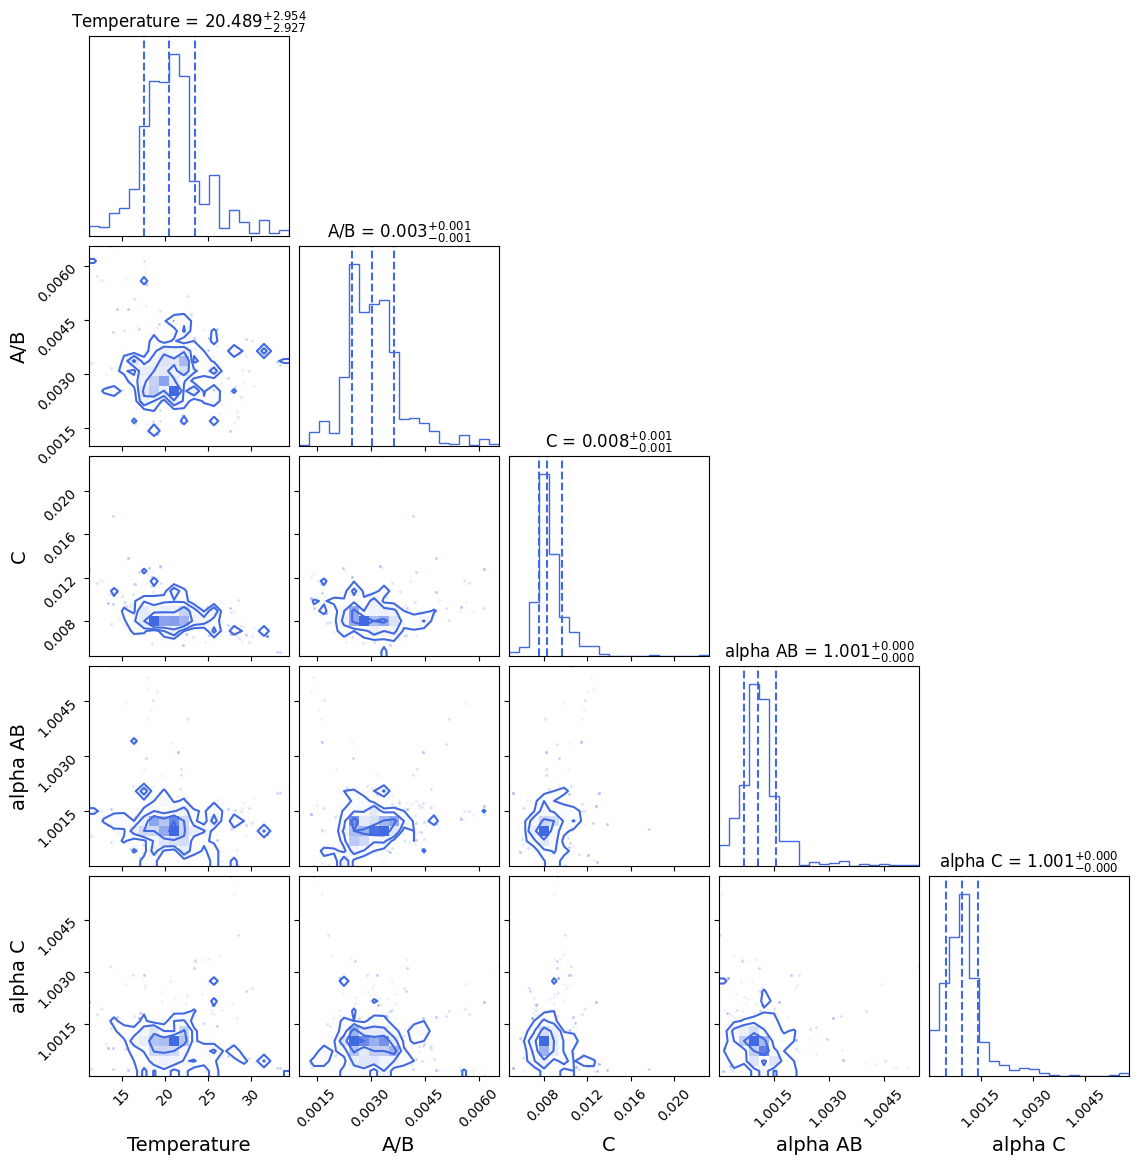

In [4]:
import corner
import numpy as np
import matplotlib.pyplot as plt

burn_in = 5
thin_factor = 1
samples = sampler.get_chain(discard=burn_in, thin=thin_factor, flat=True)

# Parameter names in the order you sampled them
labels = [
    "Temperature", 
    "A/B", 
    "C", 
    "alpha AB", 
    "alpha C"
]

# Make the corner plot
fig = corner.corner(
    samples,
    labels=labels,
    show_titles=True,
    quantiles=[0.16, 0.5, 0.84],
    title_fmt=".3f",
    title_kwargs={"fontsize": 12},
    label_kwargs={"fontsize": 14},
    smooth=0.2,  # Gaussian smoothing
    color="royalblue"
)

plt.show()


In [19]:
from tqdm import tqdm
base = osp.expanduser('~/../../scratch/gpfs/cj1223/')
orig = h5py.File(base+'pgo_outputs_original.h5', 'r')
eps = h5py.File(base+'pgo_outputs_epsilon.h5', 'r')
# Parameter grids
fraction_c_vals = orig['fraction_c'][:]
fraction_ab_vals = orig['fraction_ab'][:]
ab_vals = orig['ab_values'][:]
c_vals = orig['c_values'][:]
temperature_vals = orig['temperatures'][:]

noise_std1 = 10000*errs['var'][:, 0] 
noise_std2 = 100*errs['var'][:, 1]

noise_std1 = np.ones_like( errs['var'][:, 0] )
noise_std2 = np.ones_like( errs['var'][:, 1] )

likelihood_grid = np.empty((len(fraction_c_vals), len(fraction_ab_vals), len(c_vals), len(ab_vals), len(temperature_vals)))
prior_grid = np.empty((len(fraction_c_vals), len(fraction_ab_vals), len(c_vals), len(ab_vals), len(temperature_vals)))

for i_fc, fc in tqdm(enumerate(fraction_c_vals), total=len(fraction_c_vals)):
    for i_fab, fab in enumerate(fraction_ab_vals):
        for i_ab, ab in enumerate(ab_vals):
            for i_c, c0 in enumerate(c_vals):
                for i_t, T in enumerate(temperature_vals):
                    params = [T, ab, c, fab, fc]
                    prior = log_prior(params)
                    prior_grid[i_fc, i_fab, i_c, i_ab, i_t] = prior
                    val = compute_loglikelihood(orig['spectra'][:, i_fc, i_fab, i_c, i_ab, i_t], eps['spectra'][:, i_fc, i_fab, i_c, i_ab, i_t],\
                                                 data_flux, data_flux_dT, noise_std1, noise_std2, c = 25)
                    likelihood_grid[i_fc, i_fab, i_c, i_ab, i_t] = val

100%|█████████████████████████████████████████████████████████████████████████████████████| 4/4 [01:50<00:00, 27.57s/it]


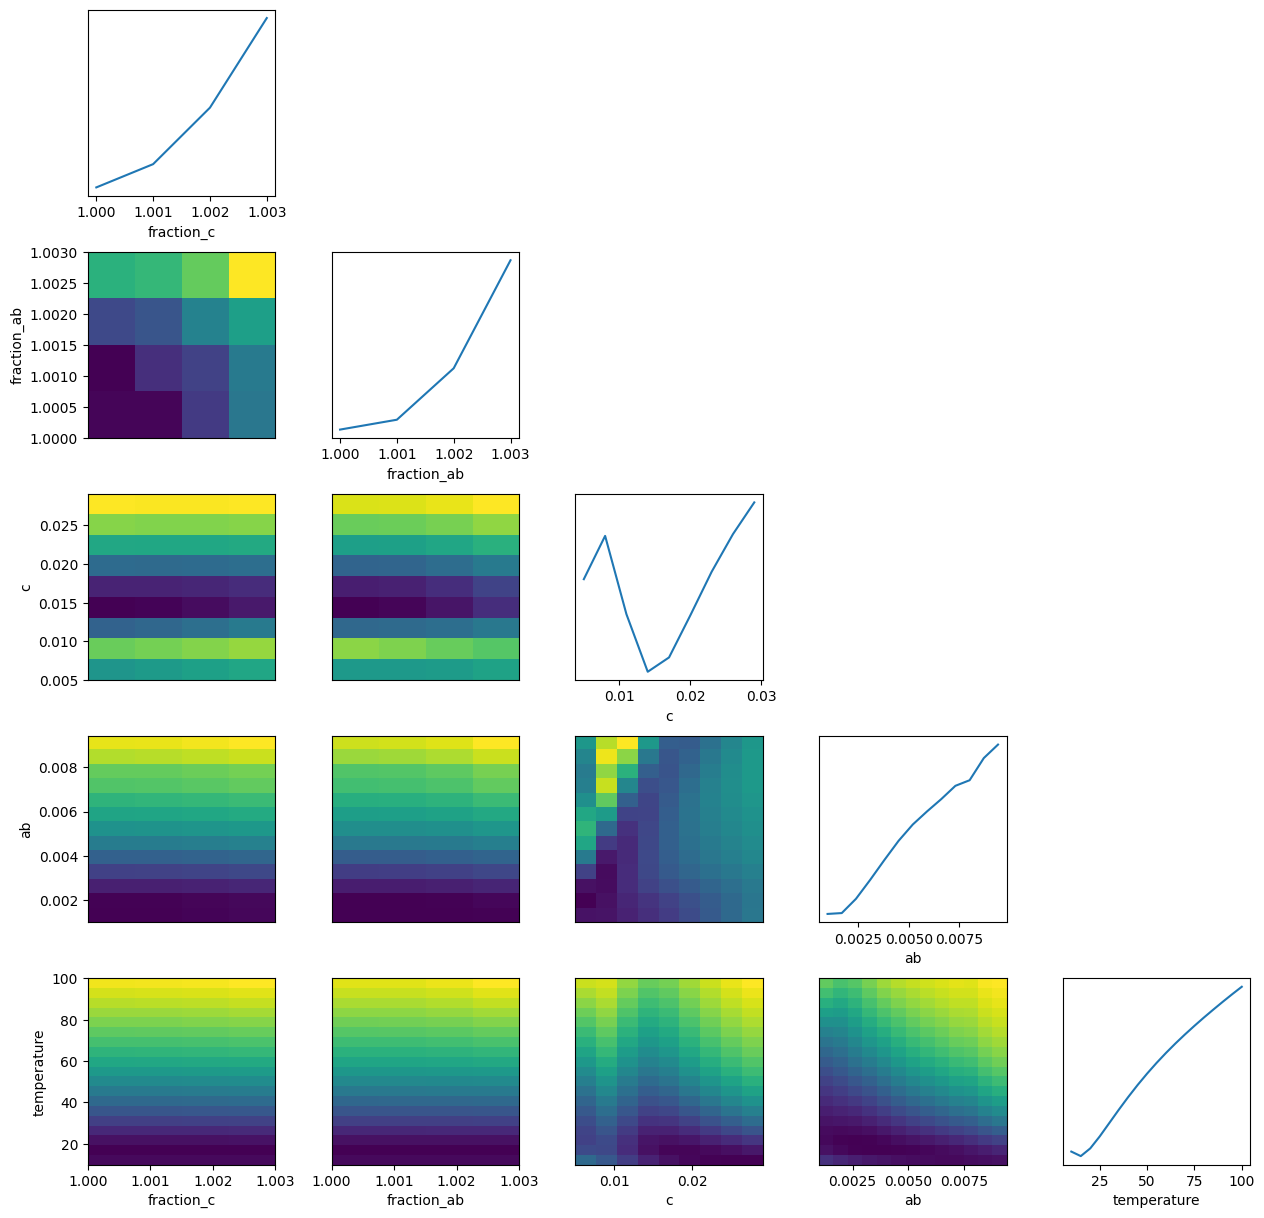

In [20]:
import matplotlib.pyplot as plt
import numpy as np

# parameter arrays (for labels and axis ticks)
param_names = ['fraction_c', 'fraction_ab', 'c', 'ab', 'temperature']
param_vals = [fraction_c_vals, fraction_ab_vals, c_vals, ab_vals, temperature_vals]

ndim = 5

# Normalize likelihoods to sum to 1
likelihoods0 = -np.copy(likelihood_grid)
# likelihoods0 += np.copy(prior)

fig, axes = plt.subplots(ndim, ndim, figsize=(15, 15))
plt.subplots_adjust(wspace=0.3, hspace=0.3)

for i in range(ndim):
    for j in range(ndim):
        ax = axes[i, j]
        if i == j:
            # 1D marginal on diagonal (sum over all but this dim)
            marg = np.sum(likelihoods0, axis=tuple(k for k in range(ndim) if k != i))
            ax.plot(param_vals[i], marg)
            ax.set_xlabel(param_names[i])
            ax.set_yticks([])
        elif i > j:
            # 2D marginal for pairs (sum over all dims except i,j)
            marg2d = np.sum(likelihoods0, axis=tuple(k for k in range(ndim) if k != i and k != j))
            # Plot 2D histogram as imshow with origin='lower'
            im = ax.imshow(
                marg2d.T,  # transpose for correct orientation
                origin='lower',
                aspect='auto',
                extent=[param_vals[j][0], param_vals[j][-1], param_vals[i][0], param_vals[i][-1]],
                cmap='viridis'
            )
            if i == ndim-1:
                ax.set_xlabel(param_names[j])
            else:
                ax.set_xticks([])
            if j == 0:
                ax.set_ylabel(param_names[i])
            else:
                ax.set_yticks([])
        else:
            ax.axis('off')

plt.show()
